In [196]:
import gym
import mgym 
import random
from mgym.envs.snake_env import SnakeEnv
import matplotlib.pyplot as plt
import sys
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
env = SnakeEnv(30,30)
env.reset(1)

print(env.observation_space)
print(env.action_space)


Box(30, 30)
Tuple(Discrete(4))


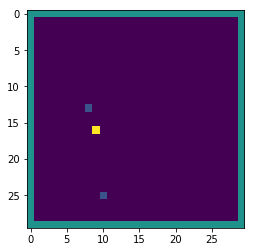

In [198]:
plt.imshow(env.grid)
plt.show()

In [99]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class QNetwork(nn.Module):
#     """Actor (Policy) Model."""

#     def __init__(self, state, action_size,hidden_layers,seed,drop_p=0.5):
#         """Initialize parameters and build model.
#         Params
#         ======
#             state_size (int): Dimension of each state
#             hidden layers : takes in a list of hidden layer dimensions, to be able to initialise a model with multiple layers
#             action_size (int): Dimension of each action
#             seed (int): Random seed
#         """
#         super(QNetwork, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
#         self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
#         self.hidden_layers = nn.ModuleList([nn.Linear(state_size,hidden_layers[0])])
#         self.hidden_layers.extend([nn.Linear(h1, h2) for h1,h2 in zip(hidden_layers[:-1], hidden_layers[1:])]) 
        
#         self.output = nn.Linear(hidden_layers[-1],action_size)
#         #self.dropout = nn.Dropout(p=drop_p)
                                             
#     def forward(self, state):
#         """Build a network that maps state -> action values."""
#         x = state
#         for linear in self.hidden_layers:
#             x = F.relu(linear(x))
#             #x = self.dropout(x)
        
#         x = self.output(x)
#         return x

In [100]:
# import numpy as np
# import random
# from collections import namedtuple, deque

# from model2 import QNetwork

# import torch
# import torch.nn.functional as F
# import torch.optim as optim

# BUFFER_SIZE = int(1e5)  # replay buffer size
# BATCH_SIZE = 64         # minibatch size
# GAMMA = 0.99            # discount factor
# TAU = 1e-3              # for soft update of target parameters
# LR = 5e-4               # learning rate 
# UPDATE_EVERY = 4        # how often to update the network

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# class Agent():
#     """Interacts with and learns from the environment."""

#     def __init__(self, state_size, action_size, seed):
#         """Initialize an Agent object.
        
#         Params
#         ======
#             state_size (int): dimension of each state
#             action_size (int): dimension of each action
#             seed (int): random seed
#         """
#         self.state_size = state_size
#         self.action_size = action_size
#         self.seed = random.seed(seed)

#         # Q-Network
#         hidden_layers = [128,64]
#         self.qnetwork_local = QNetwork(state_size, action_size, hidden_layers, seed).to(device)
#         self.qnetwork_target = QNetwork(state_size, action_size, hidden_layers, seed).to(device)
#         self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

#         # Replay memory
#         self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
#         # Initialize time step (for updating every UPDATE_EVERY steps)
#         self.t_step = 0
    
#     def step(self, state, action, reward, next_state, done):
#         # Save experience in replay memory
#         self.memory.add(state, action, reward, next_state, done)
        
#         # Learn every UPDATE_EVERY time steps.
#         self.t_step = (self.t_step + 1) % UPDATE_EVERY
#         if self.t_step == 0:
#             # If enough samples are available in memory, get random subset and learn
#             if len(self.memory) > BATCH_SIZE:
#                 experiences = self.memory.sample()
#                 self.learn(experiences, GAMMA)

#     def act(self, state, eps=0.):
#         """Returns actions for given state as per current policy.
        
#         Params
#         ======
#             state (array_like): current state
#             eps (float): epsilon, for epsilon-greedy action selection
#         """
#         state = torch.from_numpy(state).float().unsqueeze(0).to(device)
#         self.qnetwork_local.eval()
#         with torch.no_grad():
#             action_values = self.qnetwork_local(state)
#         self.qnetwork_local.train()

#         # Epsilon-greedy action selection
#         if random.random() > eps:
#             return np.argmax(action_values.cpu().data.numpy())
#         else:
#             return random.choice(np.arange(self.action_size))

#     def learn(self, experiences, gamma):
#         """Update value parameters using given batch of experience tuples.

#         Params
#         ======
#             experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
#             gamma (float): discount factor
#         """
#         states, actions, rewards, next_states, dones = experiences

        
#         max_actions = self.qnetwork_local.forward(next_states).detach().max(1)[1].unsqueeze(1)
#         output_target = self.qnetwork_target.forward(next_states).gather(1,max_actions)
#         td_target = rewards + gamma*(output_target*(1-dones))
#         output_local= self.qnetwork_local(states).gather(1, actions)
        
#         loss = F.mse_loss(output_local,td_target)
        
#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()

#         # ------------------- update target network ------------------- #
#         self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

#     def soft_update(self, local_model, target_model, tau):
#         """Soft update model parameters.
#         θ_target = τ*θ_local + (1 - τ)*θ_target

#         Params
#         ======
#             local_model (PyTorch model): weights will be copied from
#             target_model (PyTorch model): weights will be copied to
#             tau (float): interpolation parameter 
#         """
#         for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
#             target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


# class ReplayBuffer:
#     """Fixed-size buffer to store experience tuples."""

#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         """Initialize a ReplayBuffer object.

#         Params
#         ======
#             action_size (int): dimension of each action
#             buffer_size (int): maximum size of buffer
#             batch_size (int): size of each training batch
#             seed (int): random seed
#         """
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)  
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         self.seed = random.seed(seed)
    
#     def add(self, state, action, reward, next_state, done):
#         """Add a new experience to memory."""
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)
    
#     def sample(self):
#         """Randomly sample a batch of experiences from memory."""
#         experiences = random.sample(self.memory, k=self.batch_size)

#         states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         """Return the current size of internal memory."""
#         return len(self.memory)

In [211]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256,fc3_units=128,fc4_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor,self).__init__()
        self.softmax = nn.Softmax(dim=0)
        self.seed = torch.manual_seed(seed)
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5184, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,fc4_units)
        self.output = nn.Linear(fc4_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.output.weight.data.uniform_(*hidden_init(self.output))

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        
        
        x = self.convlayer1(state.reshape(-1,1,state.shape[0],state.shape[1]))
        x = self.convlayer2(x)
        #print(x.shape)
        #print(x.reshape(x.shape[2]*x.shape[3]).shape)
        x = F.relu(self.fc1(x.reshape(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        output = self.output(x)
        return self.softmax(output)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256,fc3_units=128,fc4_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic,self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5184, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units,fc3_units)
        self.fc4 = nn.Linear(fc3_units,fc4_units)
        self.output = nn.Linear(fc4_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.output.weight.data.uniform_(*hidden_init(self.output))

    def forward(self, state, action):
        """Build a critic (value) network that maps (state) pairs -> Q-values."""
        x = self.convlayer1(state.reshape(-1,1,state.shape[0],state.shape[1]))
        x = self.convlayer2(x)
        x = F.relu(self.fc1(x.reshape(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])))
        xs = F.relu(self.fc2(x))
        xs = F.relu(self.fc3(xs))
        xs = F.relu(self.fc4(xs))
        output = F.relu(self.output(xs))
        return torch.max(output)

In [212]:
test_actor = Actor(100,4,1)
test_critic = Critic(100,4,1)

In [213]:
test_actor.double()
test_critic.double()

Critic(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=4, bias=True)
)

In [214]:
test_actor.forward(torch.from_numpy(env.grid))
test_critic.forward(torch.from_numpy(env.grid),1)

tensor(19.5775, dtype=torch.float64, grad_fn=<MaxBackward1>)

In [215]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed,num_agents=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            num_agents (int) : number of agents in the environment 
        """
        
        """
        Base Working for multiple agents
        ======
        
        Many different agents will sample the environment at the same time to get different states, 
        for which based on the current policy actions will be decided, rewards will be received along with
        the next states. All the agents update the same experience replay buffer and utilise the same neural 
        net to decide on the optimal set of actions. This should theoretically increase training efficiency 
        since so many different states are being experienced at the same time.
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents,action_size),random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        #Initial target and local networks with same weights (Student Hub Discussion)
        self.hard_update(self.actor_local,self.actor_target)
        self.hard_update(self.critic_local,self.critic_target)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory."""
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions,rewards,next_states,dones):
            self.memory.add(state, action, reward, next_state, done)
    
    """To decouple learning from experience collection and use random sample from buffer to learn."""
    def update(self):
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        return np.random.choice(4,p=action)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(),1)
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def hard_update(self,local_model,target_model):
        
        for target_param,local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size,seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [216]:
print(env.grid)

[[128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128.
  128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128. 128.
  128. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0. 128.]
 [128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

In [218]:
snake1 = Agent(900,4,1)

In [219]:
action = snake1.act(env.grid,0.5)
action

0

In [220]:
timesteps = 400
epochs = 1000
max_reward = 0
rewards = {}
game_images = {}
epsilon = 1.
for i in range(epochs):
    
    if i%100==0:
        epsilon=max(0.01,epsilon-0.00001)
    iterations = 0
    env.reset(1)
    images = []
    while True:
        a = tuple([snake1.act(env.grid,epsilon)])
        #print(a)
        #print(type(a))
        state,reward,done,_ = env.step(a)
        iterations+=1
        images.append(env.grid)
#         if iterations%10==0:
#             print("epoch:",i)
#             print("timestep:",iterations)
#             plt.imshow(state)
#             plt.show()

        if done or iterations>timesteps:
            if reward[0]>max_reward:
                max_reward = reward[0]
                
            print("episode:",i,"max reward:",max_reward)
            print(rewards)
            if reward[0] not in rewards.keys():
                rewards[reward[0]] = 1
                game_images[reward[0]] = images
            else:
                rewards[reward[0]] += 1
                game_images[reward[0]] = images
            
            clear_output(wait=True)
            break

SNAKE 1 DIED!


*******************
**** GAME OVER ****
******************* 

episode: 999 max reward: 3
{1: 964, 2: 34, 3: 1}


# Observations

* It is possible that after some time, due to the lack of difference between the values of the apple and the snake element, that the snake thinks that the closest fruit is in its body itself. A possible solution to that could be that we make the snake element and fruit element values to be drastically different. To avoid this confusion.

* The reward structure can also be changed. Right now we start with 1 reward, don't penalise for dying and don't reward for staying alive, plus give reward of 1 for finding the fruit. The reward structure can be changed to heavily penalising death, giving more rewards for eating an apple, and also incentivise staying alive. 

* Plus we started with only MLP, which in my personal opinion is not scalable, as the size of the grid increases, it will be harder for the agent to process the complete space, and hence it is important for it to be able to derive features from the picture, and that can be done through a convnet.

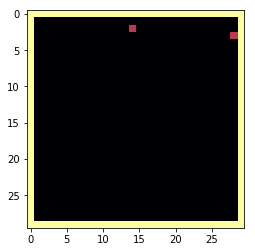

In [221]:
for i in range(len(game_images[3])):
    
    img = game_images[3][i]
    plt.imshow(img,cmap='inferno')
    #plt.savefig('./Output/output'+str(i)+'.png')
    plt.show()
    clear_output(wait=True)

In [44]:
action = Agent.forward(state)
print(action)

tensor([ 0.0877,  0.0418,  0.0182, -0.0191], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [64]:
ac = [0,1,2,3]

In [77]:
np.random.choice(4, p=[0.3, 0.2, 0.3, 0.2])

2